<img src="https://github.com/FarzadNekouee/YOLOv8_Traffic_Density_Estimation/blob/master/images/cover_image.png?raw=true" width="2400">

In [10]:
# Install YOLOv8
!pip install -q ultralytics

In [11]:
import os
import random
from glob import glob

# Set your dataset base directory
base_dir = "/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset"

# Get all image paths from train and valid folders
train_images = glob(os.path.join(base_dir, "train/images", "*.jpg"))
valid_images = glob(os.path.join(base_dir, "valid/images", "*.jpg"))

# Combine and shuffle images
all_images = train_images + valid_images
random.shuffle(all_images)

# Create dummy routes with 5 images each
num_routes = 5
images_per_route = 5
dummy_routes = {}

for i in range(num_routes):
    route_name = f"Route_{i+1}"
    dummy_routes[route_name] = all_images[i * images_per_route:(i + 1) * images_per_route]

# Print route-to-images mapping
for route, imgs in dummy_routes.items():
    print(f"{route} has {len(imgs)} images:")
    for img in imgs:
        print(f"  - {img}")


Route_1 has 5 images:
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/3_mp4-7_jpg.rf.a244ca9fac9c14239bd81b11985de853.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/10_mp4-21_jpg.rf.f4a71342a87fe4b057dfdfd961ea7f56.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/test_mp4-5_jpg.rf.26235610c8dea9da5c268fdccab4708d.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/10_mp4-2_jpg.rf.0256336d7e7d945db5ddf335f3097b71.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/2_mp4-3_jpg.rf.9df05747484088464191b55d5ff379f4.jpg
Route_2 has 5 images:
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/valid/images/2_mp4-22_jpg.rf.7e53e9a475efa9889dc0a74380255e9b.jpg
  - /kaggle/i

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Required libraries
import os
import cv2
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n.pt')

# # Set image folder paths
# base_dir = "/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset"
# train_imgs = glob(os.path.join(base_dir, "train/images", "*.jpg"))
# valid_imgs = glob(os.path.join(base_dir, "valid/images", "*.jpg"))
# all_imgs = train_imgs + valid_imgs

# Analyze class frequencies
class_counter = Counter()

for img_path in all_images:
    try:
        results = model(img_path, imgsz=640, conf=0.5)
        detections = results[0].boxes.cls.cpu().numpy()
        class_counter.update(map(int, detections))
    except:
        print(f"Error processing image: {img_path}")

# Print class frequencies
print("\n--- YOLO Class Frequencies ---")
for cls_id, count in class_counter.items():
    print(f"Class {cls_id}: {count} detections")

# Normalize and recommend weights (0.0 to 5.0 scale)
max_count = max(class_counter.values()) if class_counter else 1
recommended_weights = {cls_id: round(5.0 * (count / max_count), 2) for cls_id, count in class_counter.items()}

print("\n--- Recommended Risk Weights ---")
for cls_id, weight in recommended_weights.items():
    print(f"Class {cls_id}: Weight = {weight}")



image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/3_mp4-7_jpg.rf.a244ca9fac9c14239bd81b11985de853.jpg: 640x640 2 cars, 5.3ms
Speed: 1.9ms preprocess, 5.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/10_mp4-21_jpg.rf.f4a71342a87fe4b057dfdfd961ea7f56.jpg: 640x640 12 cars, 1 bus, 1 truck, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/test_mp4-5_jpg.rf.26235610c8dea9da5c268fdccab4708d.jpg: 640x640 3 cars, 5.2ms
Speed: 1.3ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/10_mp4-2_jpg.rf.02563

In [13]:
# Assuming you've already run the auto-analysis and now have `recommended_weights`

# Sample fallback if you want to test manually
# recommended_weights = {
#     0: 4.5,  # pedestrian
#     1: 3.0,  # bicycle
#     2: 2.0,  # car
#     3: 3.2,  # motorcycle
#     5: 3.8,  # bus
#     7: 3.6   # truck
# }

from collections import defaultdict
from ultralytics import YOLO

# Load YOLO model
model = YOLO('yolov8n.pt')

# Set congestion-related classes
vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck

# Function to compute scores
def get_scores_dynamic(model, image_paths_by_route, risk_weights):
    scores = {}

    for route_name, image_paths in image_paths_by_route.items():
        total_vehicles = 0
        total_risk = 0.0

        for img_path in image_paths:
            results = model(img_path, imgsz=640, conf=0.5)
            detections = results[0].boxes.cls.cpu().numpy()

            for cls_id in detections:
                cls_id = int(cls_id)
                if cls_id in vehicle_classes:
                    total_vehicles += 1
                if cls_id in risk_weights:
                    total_risk += risk_weights[cls_id]

        scores[route_name] = {
            'congestion_score': total_vehicles,
            'risk_score': round(total_risk, 2)
        }

    return scores

# Example:
# image_paths_by_route = {
#     'Route_1': ['/path/to/img1.jpg', '/path/to/img2.jpg'],
#     'Route_2': ['/path/to/img3.jpg', '/path/to/img4.jpg'],
# }
# scores = get_scores_dynamic(model, image_paths_by_route, recommended_weights)
# for route, data in scores.items():
#     print(f"{route} → Congestion: {data['congestion_score']}, Risk: {data['risk_score']}")


In [14]:
scores=get_scores_dynamic(model, dummy_routes, recommended_weights)
# Display the scores
for route, score in score_cong_risk.items():
    print(f"{route}:Score = {score}")


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/3_mp4-7_jpg.rf.a244ca9fac9c14239bd81b11985de853.jpg: 640x640 2 cars, 5.2ms
Speed: 1.4ms preprocess, 5.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/10_mp4-21_jpg.rf.f4a71342a87fe4b057dfdfd961ea7f56.jpg: 640x640 12 cars, 1 bus, 1 truck, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/test_mp4-5_jpg.rf.26235610c8dea9da5c268fdccab4708d.jpg: 640x640 3 cars, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/10_mp4-2_jpg.rf.02563

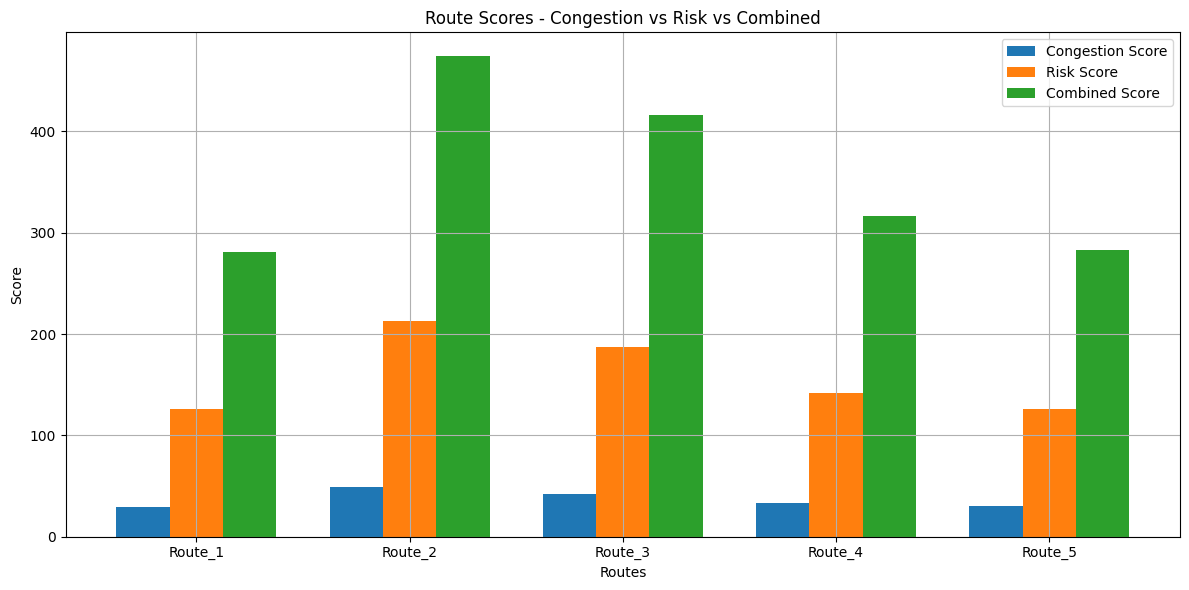


--- Adjusted A* Edge Weights ---
('A', 'B'): 38.14
('A', 'C'): 59.41
('B', 'C'): 46.58


In [15]:
import matplotlib.pyplot as plt

# # Sample output from get_scores_dynamic()
# scores = {
#     'Route_1': {'congestion_score': 15, 'risk_score': 20},
#     'Route_2': {'congestion_score': 30, 'risk_score': 5},
#     'Route_3': {'congestion_score': 25, 'risk_score': 15}
# }

# STEP 1: Combine scores using a weighted sum
alpha = 1.0  # congestion weight
beta = 2.0   # risk weight

combined_scores = {}
for route, data in scores.items():
    combined = alpha * data['congestion_score'] + beta * data['risk_score']
    combined_scores[route] = round(combined, 2)

# STEP 2: Visualize results
routes = list(combined_scores.keys())
congestion_values = [scores[r]['congestion_score'] for r in routes]
risk_values = [scores[r]['risk_score'] for r in routes]
combined_values = [combined_scores[r] for r in routes]

x = range(len(routes))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, congestion_values, width=bar_width, label='Congestion Score')
plt.bar([i + bar_width for i in x], risk_values, width=bar_width, label='Risk Score')
plt.bar([i + 2*bar_width for i in x], combined_values, width=bar_width, label='Combined Score')
plt.xlabel("Routes")
plt.ylabel("Score")
plt.title("Route Scores - Congestion vs Risk vs Combined")
plt.xticks([i + bar_width for i in x], routes)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 3: Adjusted A* Edge Weights
k = 0.1  # multiplier for combined score influence

# Original edge weights
edge_weights = {
    ('A', 'B'): 10,
    ('A', 'C'): 12,
    ('B', 'C'): 5
}

# Map routes to edges
route_map = {
    'Route_1': ('A', 'B'),
    'Route_2': ('A', 'C'),
    'Route_3': ('B', 'C')
}

# Compute adjusted edge weights
adjusted_edge_weights = {}
for route, (src, dst) in route_map.items():
    base_weight = edge_weights.get((src, dst), 0)
    adjusted_weight = base_weight + k * combined_scores[route]
    adjusted_edge_weights[(src, dst)] = round(adjusted_weight, 2)

# Print final adjusted edge weights
print("\n--- Adjusted A* Edge Weights ---")
for edge, weight in adjusted_edge_weights.items():
    print(f"{edge}: {weight}")
